# Desafío 2

En este desafío se logrará encontrar una relación explicativa entre variables y el precio por m2 de una propiedad en la Ciudad Autónoma de Buenos Aires, a partir del dataset de properati trabajado en el desafío 1, mediante una regresión lineal múltiple (analizar si es necesario combinar con procesador polinómico, y si es mejor con o sin intercepto).

Para esto se seguirán los siguientes pasos:
    1. Limpieza final del dataset
    2. Visualización: Mapa de correlaciones
    3. Preselección de variables para el modelo
    4. Creación de dummies para variables categóricas ****************Exportamos dataset para división********************* 
    5. Obtención de matriz de features (X) y vector de variable explicada (y)
    6. División de dataset en train-test para validación de modelo con randomstate(9) y test size (0.2)
    7. Normalización de set de entrenamiento por estandarización
    8. Prueba de distintos modelos (con el set de train) y evaluación de la performance con el set de test (MAE, MSE, RMSE, R2)
        a. Con dummies de localización (sin lat-lon)
           I)   Sin regularización (Se determinan los parámetros por cross-validation, dividiento el set train en k grupos)
           II)  Ridge (optimizamos parámetros usando cross-validation de forma automática con k grupos)
           III) Lasso (optimizamos parámetros usando cross-validation de forma automática con k grupos)
           IV)  Ambas (optimizamos parámetros usando cross-validation de forma automática con k grupos)
           V)   Sin regularización pero con PCA previo
        b. Sin dummies de localización (con lat-lon)
           I)   Sin regularización (Se determinan los parámetros por cross-validation, dividiento el set train en k grupos)
           II)  Ridge (optimizamos parámetros usando cross-validation de forma automática con k grupos)
           III) Lasso (optimizamos parámetros usando cross-validation de forma automática con k grupos)
           IV)  Ambas (optimizamos parámetros usando cross-validation de forma automática con k grupos)
           V)   Feature engineering
    9. Selección del mejor modelo
    10. Análisis de los resultados
        a.  Análisis de signos y valores de coeficientes de regresión
        b.  Generación de un intervalo de confianza para el precio por m2 para algún caso particular          
    


In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
import numpy as np
import unidecode
import re

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

## 1. Limpieza final del dataset

In [2]:
df = pd.read_csv('df_limpio.csv', sep = '|')

In [3]:
df.shape

(121220, 14)

In [4]:
df.columns

Index(['Unnamed: 0', 'id', 'tipo_propiedad', 'prop_subtipo', 'localidad',
       'provincia', 'precio_usd', 'superficie_m2', 'usd_m2', 'ambientes',
       'expensas', 'descripcion', 'titulo', 'geometry'],
      dtype='object')

In [5]:
df.head(2)

,Unnamed: 0,id,tipo_propiedad,prop_subtipo,localidad,provincia,precio_usd,superficie_m2,usd_m2,ambientes,expensas,descripcion,titulo,geometry
0,0,15bo8,PH,PH,Mataderos,Ciudad Autónoma de Buenos Aires,62000.0,55.0000,1127.272727,2.0,NaN,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,POINT (-58.5088387 -34.6618237)
1,1,15bob,apartment,apartment,La Plata,Buenos Aires,150000.0,70.4456,2129.302602,2.0,NaN,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,POINT (-57.96432950000001 -34.9038831)


Vemos las pertenecientes a CABA:

In [6]:
df[df['provincia'] == 'Ciudad Autónoma de Buenos Aires'].shape

(32316, 14)

Nos quedamos con las filas pertenecientes a CABA:

In [7]:
df = df[df['provincia'] == 'Ciudad Autónoma de Buenos Aires']

Vemos datos vacíos para las filas de interés:

In [8]:
df.isnull().sum()

Unnamed: 0            0
id                    0
tipo_propiedad        0
prop_subtipo          0
localidad             0
provincia             0
precio_usd            0
superficie_m2         1
usd_m2                1
ambientes          7325
expensas          25724
descripcion           0
titulo                0
geometry              0
dtype: int64

In [9]:
df.tipo_propiedad.unique()

array(['PH', 'apartment', 'house', 'store'], dtype=object)

In [10]:
df[df['tipo_propiedad'] == 'house'].isnull().sum()

Unnamed: 0           0
id                   0
tipo_propiedad       0
prop_subtipo         0
localidad            0
provincia            0
precio_usd           0
superficie_m2        1
usd_m2               1
ambientes          481
expensas          2075
descripcion          0
titulo               0
geometry             0
dtype: int64

In [11]:
df[df['tipo_propiedad'] == 'stores'].isnull().sum()

Unnamed: 0        0
id                0
tipo_propiedad    0
prop_subtipo      0
localidad         0
provincia         0
precio_usd        0
superficie_m2     0
usd_m2            0
ambientes         0
expensas          0
descripcion       0
titulo            0
geometry          0
dtype: int64

LLevamos todos los valores de expersas para casas y a stores a 0, tanto nulos como otros, para corregirlos

In [12]:
df.loc[df['tipo_propiedad'] == (('house') or ('stores')), 'expensas'] = 0

In [13]:
df[df['tipo_propiedad'] == 'house'].isnull().sum()

Unnamed: 0          0
id                  0
tipo_propiedad      0
prop_subtipo        0
localidad           0
provincia           0
precio_usd          0
superficie_m2       1
usd_m2              1
ambientes         481
expensas            0
descripcion         0
titulo              0
geometry            0
dtype: int64

Llenamos las expensas de las propiedades faltantes agrupando por propiedad y barrio

In [14]:
df.expensas.fillna(df.groupby(['tipo_propiedad', 'localidad'])['expensas'].transform('mean'), inplace=True)

In [15]:
df.isnull().sum()

Unnamed: 0           0
id                   0
tipo_propiedad       0
prop_subtipo         0
localidad            0
provincia            0
precio_usd           0
superficie_m2        1
usd_m2               1
ambientes         7325
expensas           372
descripcion          0
titulo               0
geometry             0
dtype: int64

Llenamos las faltantes con la media por barrio unicamente:

In [16]:
df.expensas.fillna(df.groupby('localidad')['expensas'].transform('mean'), inplace=True)

In [17]:
df.isnull().sum()

Unnamed: 0           0
id                   0
tipo_propiedad       0
prop_subtipo         0
localidad            0
provincia            0
precio_usd           0
superficie_m2        1
usd_m2               1
ambientes         7325
expensas             4
descripcion          0
titulo               0
geometry             0
dtype: int64

In [18]:
df[df.expensas.isnull()]

,Unnamed: 0,id,tipo_propiedad,prop_subtipo,localidad,provincia,precio_usd,superficie_m2,usd_m2,ambientes,expensas,descripcion,titulo,geometry
2763,2763,15ki9,apartment,apartment,Catalinas,Ciudad Autónoma de Buenos Aires,95000.0,48.0,1979.166667,1.0,NaN,"Edificio racionalista, Excelente departamento ...",U$D 95.000 - Departamento en Venta - Reconquis...,POINT (-58.38155746 -34.60368347)
5495,5495,15qkd,apartment,apartment_big,Catalinas,Ciudad Autónoma de Buenos Aires,550000.0,300.0,1833.333333,5.0,NaN,Amplia planta en excelente estado conservando ...,Excelente departamento antiguo en venta recicl...,POINT (-58.376624255 -34.6000039032)
63654,63654,1a96l,apartment,apartment,Catalinas,Ciudad Autónoma de Buenos Aires,322500.0,44.0,7329.545455,2.0,NaN,EXCELENTE DOS AMBIENTES MUY LUMINOSO ORIENTACI...,LINDO 2 AMB. TODO A NUEVO. APTO. PROFESIONAL,POINT (-58.3728676 -34.5976219)
73605,73605,1anwu,store,store,Catalinas,Ciudad Autónoma de Buenos Aires,350000.0,115.0,3043.478261,NaN,NaN,"""VENTA"" O ""ALQUILER"". PARA VER FOTOS Y PLANO ...",Excelente Local situado en plena zona turística.,POINT (-58.376913 -34.600861)


In [19]:
df[df.localidad == 'Catalinas']

,Unnamed: 0,id,tipo_propiedad,prop_subtipo,localidad,provincia,precio_usd,superficie_m2,usd_m2,ambientes,expensas,descripcion,titulo,geometry
2763,2763,15ki9,apartment,apartment,Catalinas,Ciudad Autónoma de Buenos Aires,95000.0,48.0,1979.166667,1.0,NaN,"Edificio racionalista, Excelente departamento ...",U$D 95.000 - Departamento en Venta - Reconquis...,POINT (-58.38155746 -34.60368347)
5495,5495,15qkd,apartment,apartment_big,Catalinas,Ciudad Autónoma de Buenos Aires,550000.0,300.0,1833.333333,5.0,NaN,Amplia planta en excelente estado conservando ...,Excelente departamento antiguo en venta recicl...,POINT (-58.376624255 -34.6000039032)
63654,63654,1a96l,apartment,apartment,Catalinas,Ciudad Autónoma de Buenos Aires,322500.0,44.0,7329.545455,2.0,NaN,EXCELENTE DOS AMBIENTES MUY LUMINOSO ORIENTACI...,LINDO 2 AMB. TODO A NUEVO. APTO. PROFESIONAL,POINT (-58.3728676 -34.5976219)
73605,73605,1anwu,store,store,Catalinas,Ciudad Autónoma de Buenos Aires,350000.0,115.0,3043.478261,NaN,NaN,"""VENTA"" O ""ALQUILER"". PARA VER FOTOS Y PLANO ...",Excelente Local situado en plena zona turística.,POINT (-58.376913 -34.600861)


Como no hay otras propiedades en Catalinas para usar de parámetro, llenamos por tipo de propiedad en general:

In [20]:
df.expensas.fillna(df.groupby('tipo_propiedad')['expensas'].transform('mean'), inplace=True)

In [21]:
df.isnull().sum()

Unnamed: 0           0
id                   0
tipo_propiedad       0
prop_subtipo         0
localidad            0
provincia            0
precio_usd           0
superficie_m2        1
usd_m2               1
ambientes         7325
expensas             0
descripcion          0
titulo               0
geometry             0
dtype: int64

Para las faltantes de ambientes, vemos la distribución:

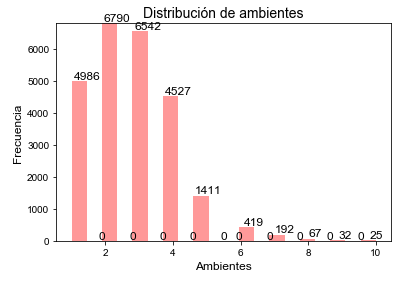

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.distplot(df['ambientes'],kde=False, color='Red', bins=20)
plt.title('Distribución de ambientes', fontsize=14)
plt.xlabel('Ambientes', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.savefig('Histograma seaborn')

import math
# Set plotting style
sns.set_style('whitegrid')

# Get current axis on current figure
ax = plt.gca()

# ylim max value to be set
y_max = df['ambientes'].value_counts().max() 
ax.set_ylim([0, y_max])

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width(), p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')

plt.show()


In [23]:
df[df.ambientes > 6].shape

(316, 14)

### Decisión: nuestro modelo explicará la variación del precio por m2 de propiedades de hasta 6 ambientes en la Ciudad de Buenos Aires

Tiramos los valores que no nos son útiles.

In [24]:
df = df[~(df.ambientes > 6)]

In [25]:
df.shape

(32000, 14)

Ahora podemos rellenar el dataset con los ambientes por media, teniendo en cuenta el subtipo de propiedad. 
Más adelante se analizará si suma o resta al modelo involucrar la variable ambientes, ya que muchos de sus datos serán estimados por la media.

In [26]:
df.ambientes.fillna(df.groupby(['prop_subtipo'])['ambientes'].transform('mean'), inplace=True)

In [27]:
df.isnull().sum()

Unnamed: 0        0
id                0
tipo_propiedad    0
prop_subtipo      0
localidad         0
provincia         0
precio_usd        0
superficie_m2     1
usd_m2            1
ambientes         0
expensas          0
descripcion       0
titulo            0
geometry          0
dtype: int64

Quedó un dato vacío en Y, vemos cuál es y lo eliminamos.

In [28]:
df[df.usd_m2.isna()]

,Unnamed: 0,id,tipo_propiedad,prop_subtipo,localidad,provincia,precio_usd,superficie_m2,usd_m2,ambientes,expensas,descripcion,titulo,geometry
24895,24895,17p8s,house,house,Congreso,Ciudad Autónoma de Buenos Aires,63000.0,NaN,NaN,1.0,0.0,"1 AMB DIVISIBLE, SE VENDE TODO EQUIPADO, BAO C...",1004,POINT (-58.391032 -34.610544)


In [29]:
df.dropna(inplace=True)

## Agregamos variables categóricas 'cochera' y 'amenities'

### regEX en busca de amenities
nos tramos las funciones de nuestra limpieza para buscar palabras clave

In [30]:
# acomodamos algunas palabras para simplificar la busqueda
df.descripcion = df.descripcion.str.replace('jacuzi','jacuzzi')
df.descripcion = df.descripcion.str.replace('picina','pileta')
df.descripcion = df.descripcion.str.replace('piscina','pileta')
df.descripcion = df.descripcion.str.replace('garage','cochera')
df.descripcion = df.descripcion.str.replace('salon de usos multiples','S.U.M.')

In [31]:
# quitamos acentos
def normalize_text(data):
    data = unidecode.unidecode(data)
    data = data.lower()
    return data

df.descripcion = df.descripcion.map(normalize_text)

In [32]:
# eliminamos el "No es apto crédito" para poder buscar "Apto crédito" sin errores
df.descripcion = df.descripcion.str.replace('no es apto credito','')

In [33]:
# establecemos una lista de amenities que nos interesa buscar
lista_am = ['cochera','pileta','jacuzzi','ping pong','parilla','s.u.m.','apto credito','apto profesional',
            'solarium','terraza propia']

In [34]:
# reestsablecemos el index
df.reset_index(inplace=True,drop=True)

In [35]:
# generamos una copia de nuestro df solo con el id
amenities = df[['id']].copy()

for i in range(len(lista_am)):
    pattern = '('+lista_am[i]+')' # establecemos el pattern dinamicamente
    regex = re.compile(pattern, flags = re.IGNORECASE)
    
    temp = df.descripcion.str.extract(pattern)     # esto nos devuelve una serie con los resultados
    temp.columns = [lista_am[i]]                   # renombramos su columna con la ammenitie buscada
    amenities = pd.concat([amenities,temp],axis=1) # concatenamos al df vacio que nos generamos 
    print(pattern)

(cochera)
(pileta)
(jacuzzi)
(ping pong)
(parilla)
(s.u.m.)
(apto credito)
(apto profesional)
(solarium)
(terraza propia)


In [36]:
# visualizamos lo encontrado
amenities.describe()

,id,cochera,pileta,jacuzzi,ping pong,parilla,s.u.m.,apto credito,apto profesional,solarium,terraza propia
count,31999,11120,5010,1729,25,119,579,2742,3858,6260,738
unique,31999,1,1,1,1,1,10,1,1,1,1
top,1c2bn,cochera,pileta,jacuzzi,ping pong,parilla,s.u.m.,apto credito,apto profesional,solarium,terraza propia
freq,1,11120,5010,1729,25,119,400,2742,3858,6260,738


In [37]:
# generamos unas dummies de forma "casera"
amenities.fillna(0,inplace=True)

for i in range(amenities.shape[1]-1):
    amenities.loc[amenities[lista_am[i]]!=0,lista_am[i]] = 1

In [38]:
# visualizamos las cantidades
datos = amenities[lista_am].describe()

# vemos que 1/3 del dataset tiene cochera, por lo que se decide utilizarla por si sola y con el resto hacer 1 sola columna
datos.loc['count']-datos.loc['freq']

cochera             11120
pileta               5010
jacuzzi              1729
ping pong              25
parilla               119
s.u.m.                579
apto credito         2742
apto profesional     3858
solarium             6260
terraza propia        738
dtype: int64

In [39]:
# renombramos las columnas cambiando " " por "_"
amen = list(amenities.columns)

new_name = []
for i in range(len(amen)):
    new_name.append(amen[i].replace(' ','_'))

amenities.columns = new_name

In [40]:
# estas las agrupamos en una variable
amenities.columns[2:]

Index(['pileta', 'jacuzzi', 'ping_pong', 'parilla', 's.u.m.', 'apto_credito',
       'apto_profesional', 'solarium', 'terraza_propia'],
      dtype='object')

In [41]:
# cochera se usa por si sola y con el resto generamos "con_amen"
amenities['con_amen'] = amenities[amenities.columns[2:]].max(axis=1)

In [42]:
np.random.seed(0)
amenities.sample(5)

,id,cochera,pileta,jacuzzi,ping_pong,parilla,s.u.m.,apto_credito,apto_profesional,solarium,terraza_propia,con_amen
31329,1cgx0,1,0,0,0,0,0,0,0,0,0,0.0
3514,16x8r,0,0,0,0,0,0,0,1,0,0,1.0
12363,199r6,0,0,0,0,0,0,0,0,0,0,0.0
25927,1biu7,0,0,0,0,0,0,0,0,0,0,0.0
31885,1ciz9,0,0,0,0,0,0,0,0,0,0,0.0


In [43]:
amenities[['cochera','con_amen']].sample(5)

,cochera,con_amen
21892,1,1.0
13496,1,0.0
25865,0,0.0
19258,0,1.0
3297,0,1.0


##### finalmente las agregamos a df

In [44]:
df['cochera'] = amenities.cochera
df['amenities'] = amenities.con_amen.astype(int)

In [45]:
df.head(3)

,Unnamed: 0,id,tipo_propiedad,prop_subtipo,localidad,provincia,precio_usd,superficie_m2,usd_m2,ambientes,expensas,descripcion,titulo,geometry,cochera,amenities
0,0,15bo8,PH,PH,Mataderos,Ciudad Autónoma de Buenos Aires,62000.0,55.000000,1127.272727,2.0,394.444444,"2 ambientes tipo casa planta baja por pasillo,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,POINT (-58.5088387 -34.6618237),0,0
1,2,15bod,apartment,apartment,Mataderos,Ciudad Autónoma de Buenos Aires,72000.0,55.000000,1309.090909,2.0,1106.250000,2 ambientes 3er piso lateral living comedor am...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,POINT (-58.5229825 -34.6522615),0,0
2,3,15boh,PH,PH,Liniers,Ciudad Autónoma de Buenos Aires,95000.0,99.871429,951.223001,3.0,475.166667,ph 3 ambientes con patio. hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,POINT (-58.5164244 -34.6477969),0,0


In [46]:
df.shape

(31999, 16)

## Modificamos la variable 'geometry' para que se pueda usar en la predicción

In [47]:
def get_points(data):
    ''' esta funcion toma un punto en STR y lo convierte en geometria'''

    data = data.strip('POINT (')
    data = data.strip(')')

    lon = float(data.split(' ')[0][:9])
    lat = float(data.split(' ')[1][:9])

    return Point(lon,lat)

# df_xl['lat'] = [df.geometry.iloc[i].y for i in range(len(df))]
# df_xl['lon'] = [df.geometry.iloc[i].x for i in range(len(df))]

In [48]:
df.columns

Index(['Unnamed: 0', 'id', 'tipo_propiedad', 'prop_subtipo', 'localidad',
       'provincia', 'precio_usd', 'superficie_m2', 'usd_m2', 'ambientes',
       'expensas', 'descripcion', 'titulo', 'geometry', 'cochera',
       'amenities'],
      dtype='object')

In [49]:
df['lat'] = [x.strip('POINT (').strip(')').split(' ')[1] for x in df.geometry]
df['lon'] = [x.strip('POINT (').strip(')').split(' ')[0] for x in df.geometry]

In [50]:
df.geometry.iloc[0].strip('POINT (').strip(')').split(' ')

['-58.5088387', '-34.6618237']

In [51]:
df.head(3)

,Unnamed: 0,id,tipo_propiedad,prop_subtipo,localidad,provincia,precio_usd,superficie_m2,usd_m2,ambientes,expensas,descripcion,titulo,geometry,cochera,amenities,lat,lon
0,0,15bo8,PH,PH,Mataderos,Ciudad Autónoma de Buenos Aires,62000.0,55.000000,1127.272727,2.0,394.444444,"2 ambientes tipo casa planta baja por pasillo,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,POINT (-58.5088387 -34.6618237),0,0,-34.6618237,-58.5088387
1,2,15bod,apartment,apartment,Mataderos,Ciudad Autónoma de Buenos Aires,72000.0,55.000000,1309.090909,2.0,1106.250000,2 ambientes 3er piso lateral living comedor am...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,POINT (-58.5229825 -34.6522615),0,0,-34.6522615,-58.5229825
2,3,15boh,PH,PH,Liniers,Ciudad Autónoma de Buenos Aires,95000.0,99.871429,951.223001,3.0,475.166667,ph 3 ambientes con patio. hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,POINT (-58.5164244 -34.6477969),0,0,-34.6477969,-58.5164244


Finalmente, eliminamos la columna unnamed e id ya que no están relacionadas con el precio y no aportan información al modelo

In [52]:
df = df[['tipo_propiedad', 'prop_subtipo', 'localidad', 'provincia', 'precio_usd', 'superficie_m2', 'usd_m2', 'ambientes',
       'expensas', 'descripcion', 'titulo', 'geometry', 'cochera', 'amenities', 'lat', 'lon']]

## 2. Visualización: Mapa de correlaciones

Con el dataset listo, realizamos un mapa de correlaciones para visualizar la importancia de cada variable para el modelo a construir:

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]), <a list of 6 Text yticklabel objects>)

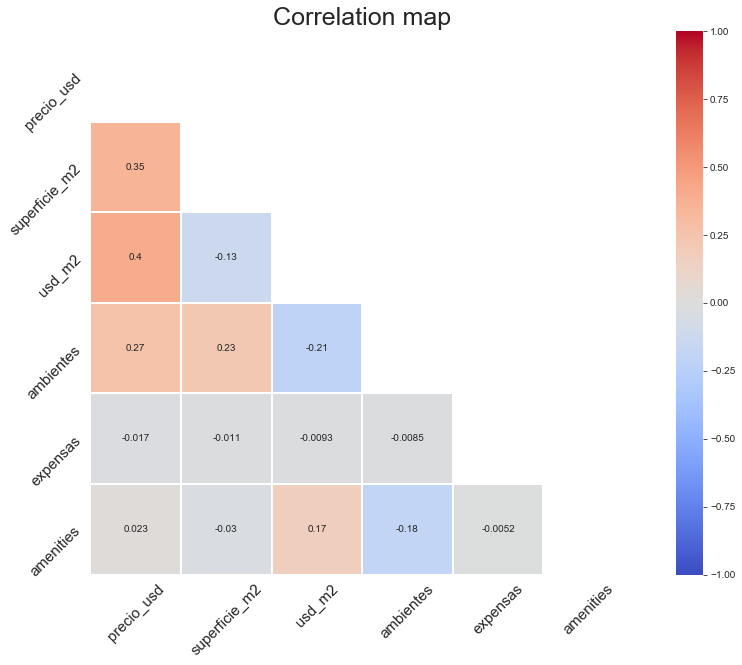

In [53]:
corr = df.corr()

mask = np.zeros(corr.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

plt.figure(figsize=(15,10))
ax = sns.heatmap(
    corr, annot=True, 
    vmin=-1, vmax=1, center=0,
    square=True, linewidths=1, mask=mask, cmap = 'coolwarm'
)


plt.title('Correlation map', size = 25)
plt.xticks(size =15, rotation=45)
plt.yticks(size =15,rotation=45)


## 3. Preselección de variables para el modelo

Vemos la poca correlación que tiene expesnas, por lo que es en principio poco útil para el modelo, por lo que, sumado a que no era una variable que viniese muy completa, se la dejará de lado para la creación del modelo.

Notamos además una altísima correlación entre el precio de la propiedad y el precio por m2, lo que es esperado ya que la primera revela información de la segunda. Por esto tampoco se la incluirá en el modelo.

Las variables restantes parecen ser de gran importancia.


## 4. Creación de dummies para variables categóricas

Usaremos el subtipo de propiedad generado y la localidad.

In [54]:
dummies = pd.get_dummies(df[['prop_subtipo', 'localidad']],prefix=['prop','loc'], drop_first=True)
# acortamos un poco el prefijo de localidad
dummies.head(2)

,prop_PH_big,prop_PH_xl,prop_apartment,prop_apartment_big,prop_apartment_xl,prop_house,prop_house_big,prop_house_xl,prop_store,prop_store_big,...,loc_Villa Lugano,loc_Villa Luro,loc_Villa Ortuzar,loc_Villa Pueyrredón,loc_Villa Real,loc_Villa Riachuelo,loc_Villa Santa Rita,loc_Villa Soldati,loc_Villa Urquiza,loc_Villa del Parque
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
df = pd.concat([df, dummies], axis='columns')

In [56]:
df.columns

Index(['tipo_propiedad', 'prop_subtipo', 'localidad', 'provincia',
       'precio_usd', 'superficie_m2', 'usd_m2', 'ambientes', 'expensas',
       'descripcion', 'titulo', 'geometry', 'cochera', 'amenities', 'lat',
       'lon', 'prop_PH_big', 'prop_PH_xl', 'prop_apartment',
       'prop_apartment_big', 'prop_apartment_xl', 'prop_house',
       'prop_house_big', 'prop_house_xl', 'prop_store', 'prop_store_big',
       'prop_store_xl', 'loc_Agronomía', 'loc_Almagro', 'loc_Balvanera',
       'loc_Barracas', 'loc_Barrio Norte', 'loc_Belgrano', 'loc_Boca',
       'loc_Boedo', 'loc_Caballito', 'loc_Capital Federal', 'loc_Catalinas',
       'loc_Centro / Microcentro', 'loc_Chacarita', 'loc_Coghlan',
       'loc_Colegiales', 'loc_Congreso', 'loc_Constitución', 'loc_Flores',
       'loc_Floresta', 'loc_Las Cañitas', 'loc_Liniers', 'loc_Mataderos',
       'loc_Monserrat', 'loc_Monte Castro', 'loc_Nuñez', 'loc_Once',
       'loc_Palermo', 'loc_Palermo Chico', 'loc_Palermo Hollywood',
       'loc_

Reindexamos para que quede como primera columna la variable objetivo: y eliminamos algunas columnas que ya no necesitamos

In [57]:
# las variables que no debemos utilizar para fitear el modelo son las 2 primeras
df = df[['usd_m2', 'precio_usd',
         
         'prop_PH_big', 'prop_PH_xl', 'prop_apartment','prop_apartment_big', 'prop_apartment_xl', 'prop_house',
         'prop_house_big', 'prop_house_xl', 'prop_store', 'prop_store_big', 'prop_store_xl',
         
         #'tipo_propiedad', 'prop_subtipo', 'localidad', 'provincia','expensas', 'descripcion', 'titulo', 'geometry',
         
         'superficie_m2', 'ambientes', 'cochera', 'amenities', 'lat','lon',
         
         'loc_Agronomía', 'loc_Almagro', 'loc_Balvanera','loc_Barracas', 'loc_Barrio Norte', 'loc_Belgrano', 'loc_Boca',
         'loc_Boedo', 'loc_Caballito', 'loc_Capital Federal', 'loc_Catalinas','loc_Centro / Microcentro', 'loc_Chacarita',
         'loc_Coghlan','loc_Colegiales', 'loc_Congreso', 'loc_Constitución', 'loc_Flores','loc_Floresta', 'loc_Las Cañitas',
         'loc_Liniers', 'loc_Mataderos','loc_Monserrat', 'loc_Monte Castro', 'loc_Nuñez', 'loc_Once','loc_Palermo',
         'loc_Palermo Chico', 'loc_Palermo Hollywood','loc_Palermo Soho', 'loc_Palermo Viejo', 'loc_Parque Avellaneda',
         'loc_Parque Centenario', 'loc_Parque Chacabuco', 'loc_Parque Chas','loc_Parque Patricios', 'loc_Paternal',
         'loc_Pompeya','loc_Puerto Madero', 'loc_Recoleta', 'loc_Retiro', 'loc_Saavedra','loc_San Cristobal',
         'loc_San Nicolás', 'loc_San Telmo','loc_Tribunales', 'loc_Velez Sarsfield', 'loc_Versalles','loc_Villa Crespo',
         'loc_Villa Devoto', 'loc_Villa General Mitre','loc_Villa Lugano', 'loc_Villa Luro', 'loc_Villa Ortuzar',
         'loc_Villa Pueyrredón', 'loc_Villa Real', 'loc_Villa Riachuelo','loc_Villa Santa Rita', 'loc_Villa Soldati',
         'loc_Villa Urquiza','loc_Villa del Parque']]

Exportamos el dataframe final, listo para trabajar:

In [60]:
# todo completo
df.isnull().sum()[df.isnull().sum()>0]

Series([], dtype: int64)

In [62]:
# columnas ordenadas y depuradas
df.head()

,usd_m2,precio_usd,prop_PH_big,prop_PH_xl,prop_apartment,prop_apartment_big,prop_apartment_xl,prop_house,prop_house_big,prop_house_xl,...,loc_Villa Lugano,loc_Villa Luro,loc_Villa Ortuzar,loc_Villa Pueyrredón,loc_Villa Real,loc_Villa Riachuelo,loc_Villa Santa Rita,loc_Villa Soldati,loc_Villa Urquiza,loc_Villa del Parque
0,1127.272727,62000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1309.090909,72000.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,951.223001,95000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3066.666667,138000.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3000.000000,195000.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
df.to_csv('df_limpio_modelo.csv',sep='|',index=None)

# HASTA ACÁ ESTÁ EN EL ARCHIVO EXPORTADO
para analizar distitos modelos comenzamos desde aqui con la importación del df_limpio_modelo.csv

In [64]:
df = pd.read_csv('df_limpio_modelo.csv',sep='|')

In [65]:
df.head()

,usd_m2,precio_usd,prop_PH_big,prop_PH_xl,prop_apartment,prop_apartment_big,prop_apartment_xl,prop_house,prop_house_big,prop_house_xl,...,loc_Villa Lugano,loc_Villa Luro,loc_Villa Ortuzar,loc_Villa Pueyrredón,loc_Villa Real,loc_Villa Riachuelo,loc_Villa Santa Rita,loc_Villa Soldati,loc_Villa Urquiza,loc_Villa del Parque
0,1127.272727,62000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1309.090909,72000.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,951.223001,95000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3066.666667,138000.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3000.000000,195000.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 5. Obtención de matriz de features (X) y vector de variable explicada (y)

Observamos las columnas de nuestro dataset actual

In [ ]:
df.columns

La columna usd_m2 representa el precio por metro cuadrado en dólares. Esta va a ser nuestra variable **target**, a la que llamaremos y.

Las columnas de superficie, ambientes y expensas, sumadas a las dummies correspondientes a las variables categóricas de subtipo de propiedad y localidad, son las posibles variables explicativas que nos permitiran llegar al valor de nuestra y. Estas serán nuestras **features** y estarán en la matriz X.


In [ ]:
y = df[['usd_m2']]

X = df.drop(['Unnamed: 0', 'tipo_propiedad', 'prop_subtipo', 'localidad', 'provincia',
             'usd_m2', 'descripcion', 'titulo', 'geometry'], axis=1)

In [ ]:
print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Type X:", type(X))
print("Type y:", type(y))

In [ ]:
X

In [ ]:
y

## 6. División de dataset en train-test para validación de modelo

Creamos una columna para estatificar, y splitear con ella.

In [ ]:
X['usd_stratify'] = pd.qcut(X['precio_usd'],4,labels=[1,2,3,4])

X = X[[x for x in X.columns if (x!='precio_usd')]]

Dividimos en train-test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X['usd_stratify'],test_size=0.2, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

## 7. Normalización de variables por estandarización para el set de train

Apliquemos estandarización, transformando las variables para que tengan media 0 $(\mu = 0)$ y desvío estándar 1 $(\sigma = 1)$, aplicando la fórmula:

$$ x' = \frac{x - \mu}{\sigma}$$

Estandarizamos feautures:

In [ ]:
# Fiteamos el estandarizador y estandarizamos con X_train

stdscaler_X = preprocessing.StandardScaler()
X_train_scaled = stdscaler_X.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Estandarizamos X_test con el estandarizador fiteado con X_train

X_test_scaled = stdscaler_X.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

#UTILIZAR INVERSE_TRANSFORM PARA ANALIZAR LOS DATOS OBTENIDOS POSTERIORMENTE


Estandarizamos target y lo centramos con una fución logarítmica, ya que su distribución es asimétrica con cola a la derecha:


In [ ]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [ ]:
#### ESTO NO LO HACE MARTIN, PERO NO LE QUEDA LA Y NORMALIZADA Y NUESTRO R2 MEJORA AL HACERLO,YO LO DEJARÍA


# Fiteamos el estandarizador y estandarizamos con y_train

stdscaler_y = preprocessing.StandardScaler()
y_train_scaled = stdscaler_y.fit_transform(y_train)
y_train = pd.DataFrame(y_train_scaled, columns=y_train.columns)

# Estandarizamos y_test con el estandarizador fiteado con y_train

y_test_scaled = stdscaler_y.transform(y_test)
y_test = pd.DataFrame(y_test_scaled, columns=y_test.columns)

#UTILIZAR INVERSE_TRANSFORM PARA ANALIZAR LOS DATOS OBTENIDOS POSTERIORMENTE

Vemos que todo esté bien

In [ ]:
display(X_train)

In [ ]:
y_train

Verificamos que estén normalizadas y verificamos que:

   + $\bar{x_{j}} \approx 0$
    
   + $s_{j}=1.00002$

In [ ]:
X_train.apply(['mean','std']).T

In [ ]:
y_train.apply(['mean','std']).T

## 8. Prueba de distintos modelos (con el set de train) y evaluación de la performance con el set de test (MAE, MSE, RMSE, R2)
  
a. Con dummies de localización (sin lat-lon)

    I)   Sin regularización (Se determinan los parámetros por cross-validation, dividiento el set train en k grupos)
   
    II)  Ridge (optimizamos parámetros usando cross-validation de forma automática con k grupos)

    III) Lasso (optimizamos parámetros usando cross-validation de forma automática con k grupos)

    IV)  Ambas (optimizamos parámetros usando cross-validation de forma automática con k grupos)

    V)   Sin regularización pero con PCA previo
   
b. Sin dummies de localización (con lat-lon)

    I)   Sin regularización (Se determinan los parámetros por cross-validation, dividiento el set train en k grupos)
   
    II)  Ridge (optimizamos parámetros usando cross-validation de forma automática con k grupos)
   
    III) Lasso (optimizamos parámetros usando cross-validation de forma automática con k grupos)
   
    IV)  Ambas (optimizamos parámetros usando cross-validation de forma automática con k grupos)
   
    V)   Feature engineering
   

## 8.a. Con dummies de localización (sin lat-lon)

### 8.a. I) Sin regularización (Se determinan los parámetros por cross-validation, dividiento el set train en k grupos)


#### a) Con Intercepto

Instanciamos el modelo

In [ ]:
lm = LinearRegression()

Fiteamos el modelo, para que aprenda de los datos.

In [ ]:
model = lm.fit(X_train, y_train)

El modelo ya determinó sus coeficientes de regresión (betas). Los vemos

In [ ]:
np.set_printoptions(precision=3, suppress=True)

print('Intercept Linear model: ',lm.intercept_,'\n',
      'Coefs Linear model:',lm.coef_,'\n')

Vemos la performance del modelo sobre sus propios datos de train

In [ ]:
# Calculamos el R2

print(" Score Train Lineal: %.5f\n" % lm.score(X_train, y_train))

# Calculamos el RMSE

y_pred_tr_lm = lm.predict(X_train)

rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

print(" Train RMSE lineal   : %.5f \n" % rmse(y_train,y_pred_tr_lm))

# Calculamos el MAE

print (' MAE: %.5f\n' % metrics.mean_absolute_error(y_train,y_pred_tr_lm))

# Calculamos el MSE

print (' MSE: %.5f\n' % metrics.mean_squared_error(y_train,y_pred_tr_lm))

Evaluamos el modelo sobre el set de test:

In [ ]:
# Hacemos las predicciones sobre la matriz de predictores del Test Set

y_pred_lm = lm.predict(X_test)

print(" Score Test Lineal: %.5f\n" % lm.score(X_test, y_test))
print(" Test RMSE lineal= %.2f\n" % rmse(y_test, y_pred_lm))

#### b) Sin Intercepto


Se toma intercepto nulo ya que el valor del m2 para valores de X = 0, es 0. Veremos que el resultado es el mismo, ya que el modelo anterior, llevaba el intercepto a 0.

In [ ]:
lm2 = LinearRegression(fit_intercept=False)

Fiteamos el modelo, para que aprenda de los datos.

In [ ]:
model2 = lm2.fit(X_train, y_train)

El modelo ya determinó sus coeficientes de regresión (betas). Los vemos

In [ ]:
np.set_printoptions(precision=3, suppress=True)

print('Intercept Linear model: ',lm2.intercept_,'\n',
      'Coefs Linear model:',lm2.coef_,'\n')

Vemos la performance del modelo sobre sus propios datos de train

In [ ]:
# Calculamos el R2

print(" Score Train Lineal: %.5f\n" % lm2.score(X_train, y_train))

# Calculamos el RMSE

y_pred_tr_lm2 = lm2.predict(X_train)

rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

print(" Train RMSE lineal   : %.5f \n" % rmse(y_train,y_pred_tr_lm2))

# Calculamos el MAE

print (' MAE: %.5f\n' % metrics.mean_absolute_error(y_train,y_pred_tr_lm2))

# Calculamos el MSE

print (' MSE: %.5f\n' % metrics.mean_squared_error(y_train,y_pred_tr_lm2))

SObre el set de test:

In [ ]:
# Hacemos las predicciones sobre la matriz de predictores del Test Set

y_pred_lm2 = lm2.predict(X_test)

print(" Score Test Lineal: %.5f\n" % lm2.score(X_test, y_test))
print(" Test RMSE lineal= %.5f\n" % rmse(y_test, y_pred_lm2))

### Analizamos la regresión lineal con statsmodel para eliminar variables con coeficientes no significativos

### 8.a. II) Ridge (Se setea el modelo para que optimice parámetros usando cross-validation de forma automática con k grupos)

Instanciamos el modelo, generando un grid de $\alpha$ para probar e instanciamos un particionador en k partes para la cross-validation

In [ ]:
al_ridge = np.linspace(0.001, 0.3, 300)

kf = KFold(n_splits=5, shuffle=True, random_state=0)

lm_ridge_cv= RidgeCV(alphas=al_ridge, cv=kf, normalize=False)

Fiteamos el modelo, para que aprenda de los datos. 

In [ ]:
lm_ridge_cv.fit(X_train, y_train)

EL modelo ya determina sus coeficientes de regresión y su hiperparámetro. Los vemos

In [ ]:
np.set_printoptions(precision=3, suppress=True)

print('Alpha Ridge:',lm_ridge_cv.alpha_,'\n',
      'Intercept Ridge: ',lm_ridge_cv.intercept_,'\n',
      'Coefs Ridge:',lm_ridge_cv.coef_,'\n')


Vemos la performance del modelo sobre sus propios datos de train

In [ ]:
# Calculamos el R2

print("Score Train Ridge : %.5f\n" % lm_ridge_cv.score(X_train, y_train))

# Calculamos el RMSE

y_pred_tr_ridge = lm_ridge_cv.predict(X_train)

rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

print("Train RMSE Ridge    : %.5f \n" % rmse(y_train,y_pred_tr_ridge))

# Calculamos el MAE

print (' MAE: %.5f\n' % metrics.mean_absolute_error(y_train,y_pred_tr_ridge))

# Calculamos el MSE

print (' MSE: %.5f\n' % metrics.mean_squared_error(y_train,y_pred_tr_ridge))

SObre el set test

In [ ]:
# Hacemos las predicciones sobre la matriz de predictores del Test Set

y_pred_ridge = lm_ridge_cv.predict(X_test)

print(" Score Test Ridge: %.5f\n" % lm_ridge_cv.score(X_test, y_test))
print(" Test RMSE Ridge= %.f\n" % rmse(y_test, y_pred_ridge))

### 8.a. III) Lasso (Se setea el modelo para que optimice parámetros usando cross-validation de forma automática con k grupos)

De la misma forma que antes, hacemos:

In [ ]:
al_lasso = np.linspace(0.1, 0.5, 300)

kf = KFold(n_splits=5, shuffle=True, random_state=0)

lm_lasso_cv = LassoCV(alphas=al_lasso, cv=kf, normalize=False)

In [ ]:
lm_lasso_cv.fit(X_train, y_train)

In [ ]:
np.set_printoptions(precision=3, suppress=True)

print('Alpha Lasso:',lm_lasso_cv.alpha_,'\n'
      'Intercept Lasso: ',lm_ridge_cv.intercept_,'\n'
      'Coefs Lasso:',lm_lasso_cv.coef_,'\n')

Análisis de las variables que elimina.

In [ ]:
# Calculamos el R2

print("Score Train Lasso : %.5f\n" % lm_lasso_cv.score(X_train, y_train))

# Calculamos el RMSE

y_pred_tr_lasso = lm_lasso_cv.predict(X_train)

rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

print("Train RMSE Lasso    : %.5f \n" % rmse(y_train,y_pred_tr_lasso))

# Calculamos el MAE

print (' MAE: %.5f\n' % metrics.mean_absolute_error(y_train,y_pred_tr_lasso))

# Calculamos el MSE

print (' MSE: %.5f\n' % metrics.mean_squared_error(y_train,y_pred_tr_lasso))

Sobre el set test

In [ ]:
# Hacemos las predicciones sobre la matriz de predictores del Test Set

y_pred_lasso = lm_lasso_cv.predict(X_test)

print(" Score Test Lasso: %.5f\n" % lm_lasso_cv.score(X_test, y_test))
print(" Test RMSE Lasso= %.f\n" % rmse(y_test, y_pred_lasso))

### 8.a. IV) Ambas (Se setea el modelo para que optimice parámetros usando cross-validation de forma automática con k grupos)

###  8.a. V)   Sin regularización pero con PCA previo

In [ ]:
from sklearn.decomposition import PCA

# Instanciamos la clase PCA:
pca_prop = PCA()

# Al no especificar el número de componentes, PCA va a conservar todos los CP.

# Calculamos los componentes principales con el método fit()
pca_prop.fit(X_train)

In [ ]:
# Creamos un DataFRame con los loadings:

pca_loadings = pd.DataFrame(pca_prop.components_.T,index=X_train.columns)
pca_loadings

In [ ]:
# Verificamos la ortonormalidad de los componentes principales:

pca_loadings.T.dot(pca_loadings)

In [ ]:
# Generamos un DataFrame expresando en términos de nuestros componentes principales:

df_pca = pd.DataFrame(pca_prop.fit_transform(X_train),
                      index=X_train.index)
df_pca.head()

In [ ]:
# Observamos la media de las variables:
print("Media de los CP: ")
print(df_pca.mean(axis=0))

print('\n')

# Observamos la varianza de las variables:
print("Varianza de los CPs: ")
print(df_pca.var(axis=0))

In [ ]:
# Vemos la varianza explicada de cada componente principal como atributo del modelo.

pca_prop.explained_variance_

In [ ]:
# Vemos el ratio la varianza explicada de cada componente principal como atributo del modelo.

pca_prop.explained_variance_ratio_

In [ ]:
# Vemos el ratio acumulado de variaza explicada. El 

np.cumsum(pca_prop.explained_variance_ratio_)

Vemos que el 80% de la varianza se explica usando hasta la componente 55. Probamos un modelo de regresión con estas variables nuevas.

In [ ]:
pca_prop = PCA(n_components=55, svd_solver="full")

In [ ]:
pca_prop.fit(X_train)

In [ ]:
df_pca = pd.DataFrame(pca_prop.fit_transform(X_train),
                      index=X_train.index)

Instanciamos el modelo

In [ ]:
lm_pca = LinearRegression()

Fiteamos el modelo, para que aprenda de los datos.

In [ ]:
model = lm_pca.fit(df_pca, y_train)

El modelo ya determinó sus coeficientes de regresión (betas). Los vemos

In [ ]:
np.set_printoptions(precision=3, suppress=True)

print('Intercept Linear model: ',lm_pca.intercept_,'\n',
      'Coefs Linear model:',lm_pca.coef_,'\n')

Vemos la performance del modelo sobre sus propios datos de train

In [ ]:
# Calculamos el R2

print(" Score Train Lineal PCA: %.5f\n" % lm_pca.score(df_pca, y_train))

# Calculamos el RMSE

y_pred_tr_lm_pca = lm_pca.predict(df_pca)

rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

print(" Train RMSE lineal PCA  : %.5f \n" % rmse(y_train,y_pred_tr_lm_pca))

# Calculamos el MAE

print (' MAE: %.5f\n' % metrics.mean_absolute_error(y_train,y_pred_tr_lm_pca))

# Calculamos el MSE

print (' MSE: %.5f\n' % metrics.mean_squared_error(y_train,y_pred_tr_lm_pca))

Evaluamos sobre el set de test, pasandolo a términos del PCA



In [ ]:
y_test = pca_prop.transform(y_test)

X_test = pca_prop.transform(X_test)

In [ ]:
# Hacemos las predicciones sobre la matriz de predictores del Test Set

#y_pred_lm_pca = lm_pca.predict(X_test)

#print(" Score Test Ridge: %.5f\n" % lm_pca.score(X_test, y_test))
#print(" Test RMSE Ridge= %.f\n" % rmse(y_test, y_pred_lm_pca))

## 8.b. Sin dummies de localización (con lat-lon)

## 9. Selección del mejor modelo

## 10. Análisis de los resultados

I)  Análisis de signos y valores de coeficientes de regresión
    
II)  Generación de un intervalo de confianza para el precio por m2 para algún caso particular 

### I)  Análisis de signos y valores de coeficientes de regresión

### II) Generación de un intervalo de confianza para el precio por m2 para algún caso particular